In [5]:
library(forecast)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Aggregated TS

In [6]:
df_eu  <-  read.csv(file="hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )

In [7]:
gdp_agg <- df_eu_sums <-  rowSums(df_eu)

In [8]:
gdp_agg %>% head()

2005-01-01 2005-04-01 2005-07-01 2005-10-01 2006-01-01 2006-04-01 
  14811633   14902341   15023371   15102282   15315296   15359039

In [9]:
gdp_agg  <- ts(gdp_agg, frequency = 4, start = 2005) 

In [10]:
train <- window(gdp_agg, end=c(2016,4))
test <- window(gdp_agg, start=c(2017,1))

#### Модель 0: RW with drift

The random walk with drift model is

$$Y_t=c + Y_{t-1} + Z_t$$

``rwf(y, h, drift=TRUE)``

#### Модель 1: Theta

``library(foreast)``

Equivalent to simple exponential smoothing with drift 

$\sim$ ETS(AAdN)

In [11]:
gdp_rwf <- rwf(train,h=6)
gdp_rwfwd <- rwf(train,h=6, drift=TRUE)
gdp_snaive  <- snaive(train,h=6)
gdp_theta  <- thetaf(train, h=6)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=6)
gdp_auto_arima  <- forecast(auto.arima(train), h=6)
gdp_ets <- forecast(ets(train), h=6)

In [12]:
cat("RW")
accuracy(gdp_rwf, test)[, c(2,5,7,8)]
cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("SNaive")
accuracy(gdp_snaive, test)[, c(2,5,7,8)]
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("ETS")
accuracy(gdp_ets, test)[, c(2,5,7,8)]

RW

,RMSE,MAPE,ACF1,Theil's U
Training set,114906.1,0.585723,0.3099162,NA
Test set,423450.4,2.082052,0.4282787,3.559654


RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,100521.9,0.4456937,0.3099162,NA
Test set,207596.0,0.9933801,0.3503872,1.747803


SNaive

,RMSE,MAPE,ACF1,Theil's U
Training set,348836.9,1.981452,0.8375712,NA
Test set,526012.3,2.721704,0.4681269,4.340228


Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,112376.3,0.5581504,0.3244200,NA
Test set,334054.3,1.6475709,0.4586461,2.803655


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,77813.43,0.3608726,0.02393859,NA
Test set,298475.11,1.5011194,0.45297756,2.496156


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,94584.52,0.4287515,-0.03029743,NA
Test set,205317.30,0.9807683,0.34939863,1.72868


ETS

,RMSE,MAPE,ACF1,Theil's U
Training set,103117.0,0.510353,-0.02390457,NA
Test set,314885.8,1.503868,0.40907167,2.649543


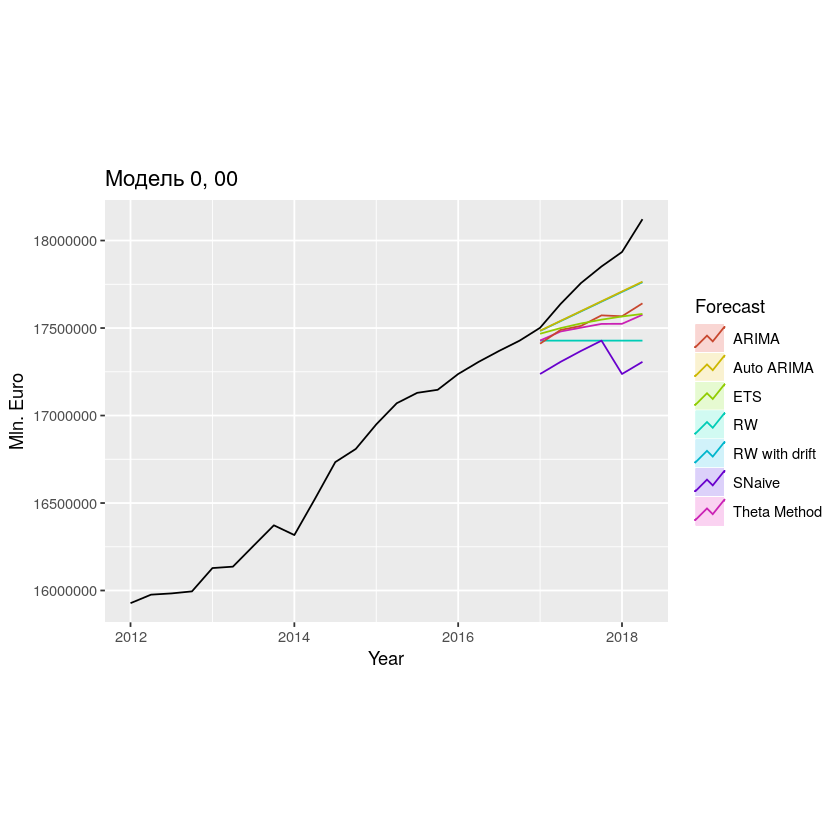

In [13]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwf, series="RW", PI=FALSE) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_snaive, series="SNaive", PI=FALSE) +
    autolayer(gdp_theta, series="Theta Method", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_ets, series="ETS", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)

### strucchange

In [14]:
library(strucchange)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich



	 Optimal 2-segment partition: 

Call:
breakpoints.Fstats(obj = fs.gdp_agg)

Breakpoints at observation number:
15 

Corresponding to breakdates:
2008(3) 

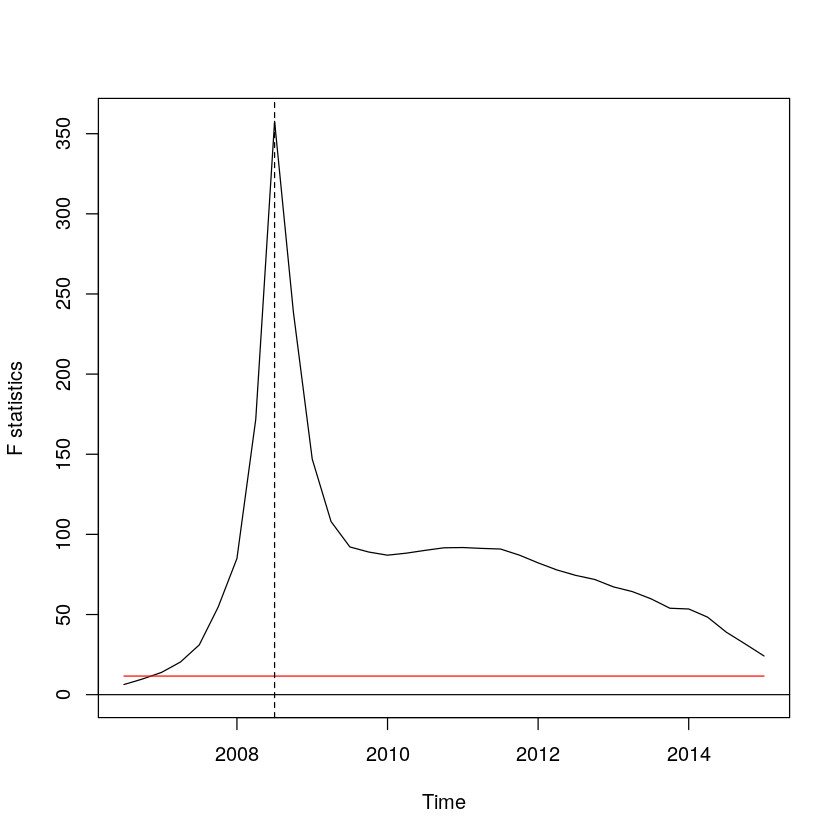

In [15]:
## F statistics indicate one breakpoint
fs.gdp_agg <- Fstats(train  ~  1 + time(train))
plot(fs.gdp_agg)
breakpoints(fs.gdp_agg)
lines(breakpoints(fs.gdp_agg))

In [16]:
breakpoints(fs.gdp_agg)[[1]] 

[1] 15

In [25]:
dum  <-  rep(c(0,1), c(breakpoints(fs.gdp_agg)[[1]], length(gdp_agg) - breakpoints(fs.gdp_agg)[[1]]))
dum2  <-  rep(c(0,1), c(16,length(gdp_agg)-16))

In [26]:
all(dum == dum2)

[1] FALSE

https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/R-comments.pdf

In [27]:
library(zoo)

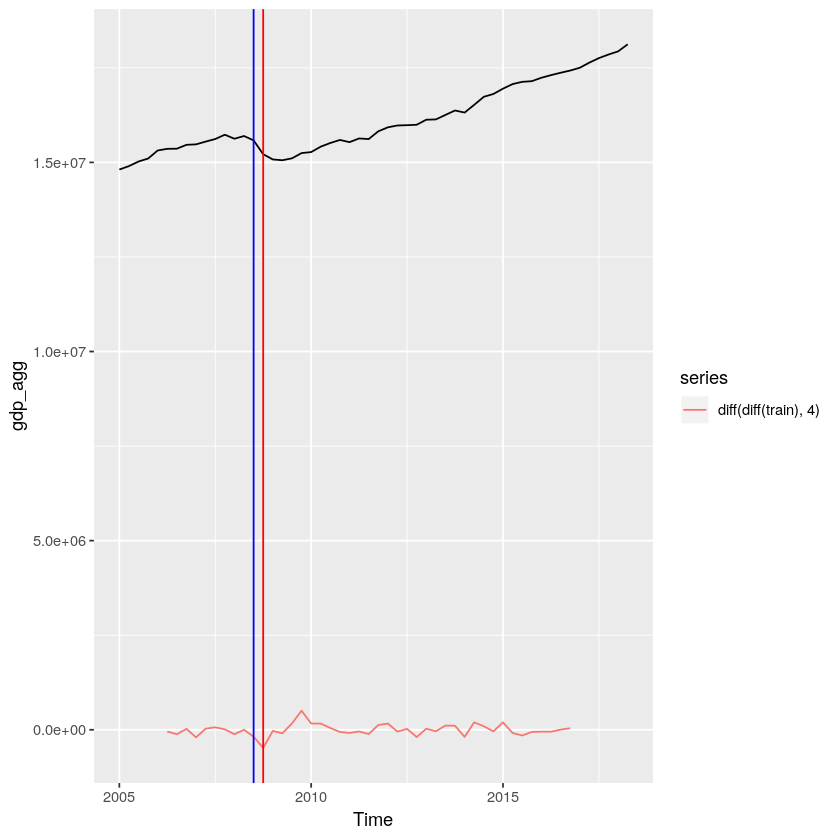

In [29]:
autoplot(gdp_agg) +
    autolayer(diff(diff(train),4)) + 
    geom_vline(xintercept=c(time(gdp_agg)[breakpoints(fs.gdp_agg)[[1]]],time(gdp_agg)[16]), col=c("blue", "red"))

In [37]:
auto.arima(train)
auto.arima(train, xreg=dum[1:48])

Series: train 
ARIMA(1,1,0) with drift 

Coefficients:
         ar1     drift
      0.3043  56012.89
s.e.  0.1371  19853.74

sigma^2 estimated as 9.543e+09:  log likelihood=-605.71
AIC=1217.42   AICc=1217.98   BIC=1222.97

Series: train 
Regression with ARIMA(0,1,0) errors 

Coefficients:
         drift       xreg
      64831.95  -430780.3
s.e.  11647.37    79856.1

sigma^2 estimated as 6.523e+09:  log likelihood=-596.72
AIC=1199.43   AICc=1199.99   BIC=1204.98

In [38]:
gdp_rwfwd <- rwf(train,h=7, drift=TRUE)
gdp_snaive  <- snaive(train,h=7)
gdp_theta  <- thetaf(train, h=7)
gdp_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2)), h=7)
gdp_auto_arima  <- forecast(auto.arima(train), h=7)
gdp_str_arima  <- forecast(auto.arima(train,  xreg=dum[1:48]), 7, xreg = dum[49:54])
# gdp_str2_arima  <-  forecast(auto.arima(train, lambda = 'auto', xreg=dum2[1:68]), 7, xreg = dum2[69:75])
gdp_str3_arima  <- forecast(Arima(train, order=c(2,1,2), seasonal=c(2,1,2),  xreg=dum[1:48]), h=7, xreg = dum[49:54])

cat("RW with drift ")
accuracy(gdp_rwfwd, test)[, c(2,5,7,8)]
cat("Theta")
accuracy(gdp_theta, test)[, c(2,5,7,8)]
cat("ARIMA")
accuracy(gdp_arima, test)[, c(2,5,7,8)]
cat("ARIMA 2009")
accuracy(gdp_str3_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA")
accuracy(gdp_auto_arima, test)[, c(2,5,7,8)]
cat("Auto ARIMA str")
accuracy(gdp_str_arima, test)[, c(2,5,7,8)]
# cat("Auto ARIMA 2009")
# accuracy(gdp_str2_arima, test)[, c(2,5,7,8)]


Warning message in forecast.Arima(auto.arima(train, xreg = dum[1:48]), 7, xreg = dum[49:54]):
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”Warning message in forecast.Arima(Arima(train, order = c(2, 1, 2), seasonal = c(2, :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”

RW with drift 

,RMSE,MAPE,ACF1,Theil's U
Training set,100521.9,0.4456937,0.3099162,NA
Test set,207596.0,0.9933801,0.3503872,1.747803


Theta

,RMSE,MAPE,ACF1,Theil's U
Training set,112376.3,0.5581504,0.3244200,NA
Test set,334054.3,1.6475709,0.4586461,2.803655


ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,77813.43,0.3608726,0.02393859,NA
Test set,298475.11,1.5011194,0.45297756,2.496156


ARIMA 2009

,RMSE,MAPE,ACF1,Theil's U
Training set,73029.38,0.3651021,-0.002939609,NA
Test set,197714.69,0.9794394,0.288575465,1.661932


Auto ARIMA

,RMSE,MAPE,ACF1,Theil's U
Training set,94584.52,0.4287515,-0.03029743,NA
Test set,205317.30,0.9807683,0.34939863,1.72868


Auto ARIMA str

,RMSE,MAPE,ACF1,Theil's U
Training set,78197.54,0.3703405,-0.04578067,NA
Test set,172280.56,0.8141291,0.31967323,1.450845


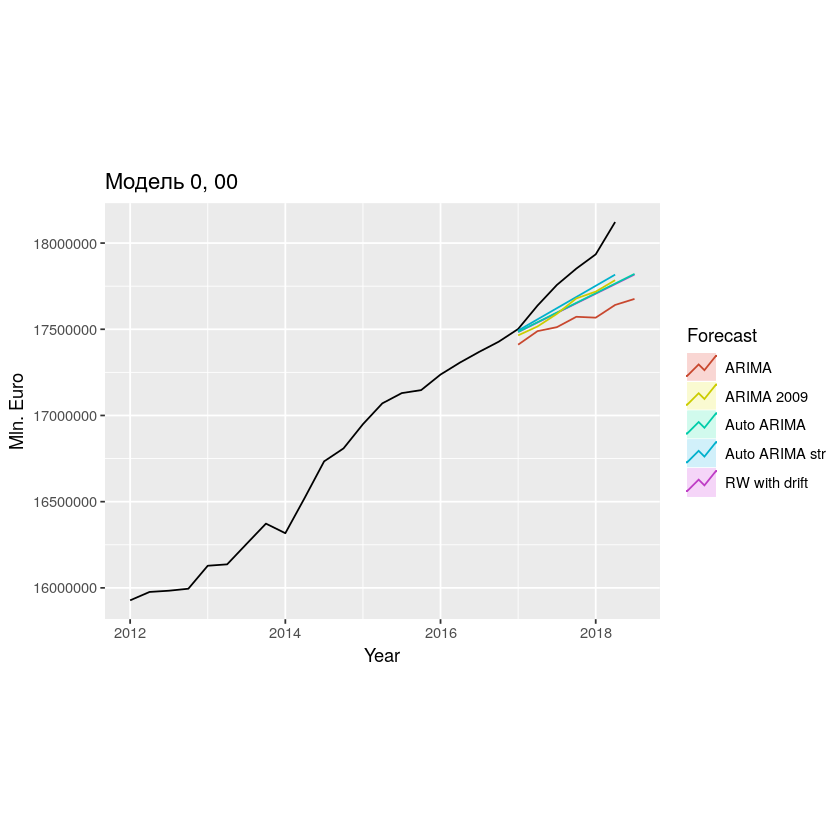

In [39]:
autoplot(window(gdp_agg, start=2012)) +
    autolayer(gdp_rwfwd, series="RW with drift", PI=FALSE) +
    autolayer(gdp_arima, series="ARIMA", PI=FALSE) +
    autolayer(gdp_auto_arima, series="Auto ARIMA", PI=FALSE) +
    autolayer(gdp_str_arima, series="Auto ARIMA str", PI=FALSE) +
#     autolayer(gdp_str2_arima, series="Auto ARIMA 2009", PI=FALSE) +
    autolayer(gdp_str3_arima, series="ARIMA 2009", PI=FALSE) +
    xlab("Year") + ylab("Mln. Euro") +
    ggtitle("Модель 0, 00") +
    guides(colour=guide_legend(title="Forecast")) +
    theme(aspect.ratio = 0.75)